<a href="https://colab.research.google.com/github/nlionf/projects/blob/main/FinalAssignmentUdemy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project
## Udemy Course: Machine Learning, Data Science and Deep Learning with Python

## Predicting whether a mammogram mass is benign or malignant

We'll be using the "mammographic masses" public dataset from the UCI repository (source: https://archive.ics.uci.edu/ml/datasets/Mammographic+Mass)

This data contains 961 instances of masses detected in mammograms, and contains the following attributes:


   1. BI-RADS assessment: 0 to 6  
   2. Age: patient's age in years
   3. Shape: mass shape: round=1 oval=2 lobular=3 irregular=4
   4. Margin: mass margin: circumscribed=1 microlobulated=2 obscured=3 ill-defined=4 spiculated=5
   5. Density: mass density high=1 iso=2 low=3 fat-containing=4
   6. Severity: benign=0 or malignant=1

In [1]:
# installing the kaleido engine to display graphs within the notebook
!pip install kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 79.9 MB 130 kB/s 


In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import kaleido

In [4]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [5]:
cols = ['BI_RADS', 'age', 'shape', 'margin', 'density', 'severity']
data = pd.read_csv(r'/content/drive/MyDrive/Colab_Files/FinalAssignmentUdemy/mammographic_masses.data.txt', names=cols, na_values='?')
data.head()

,BI_RADS,age,shape,margin,density,severity
0,5.0,67.0,3.0,5.0,3.0,1
1,4.0,43.0,1.0,1.0,NaN,1
2,5.0,58.0,4.0,5.0,3.0,1
3,4.0,28.0,1.0,1.0,3.0,0
4,5.0,74.0,1.0,5.0,NaN,1


## Understanding the data

### BI-RADS *(Breast Imaging-Reporting and Data System)*

Does the BI-RADS score tell us if a given mass is malignant or benign?

(or in other words: is using it to predict malignancy considered cheating?)<br><br>

First we must understand the meaning of each BI-RADS score, and then we will assess its relevance to the classification task at hand.

From the dataset's description:

"*Each instance has an associated BI-RADS assessment ranging from 1 (definitely benign) to 5 (highly suggestive of malignancy) assigned in a double-review process by physicians.*"<br><br>

Radiopaedia.org provides [an in-depth explanation of BI-RADS assessments](https://radiopaedia.org/articles/breast-imaging-reporting-and-data-system-bi-rads):

- BI-RADS 0: incomplete
need additional imaging evaluation (additional mammographic views or ultrasound) and/or
for mammography, obtaining previous images not available at the time of reading

- BI-RADS 1: negative
symmetrical and no masses, architectural distortion, or suspicious calcifications

- BI-RADS 2: benign
0% probability of malignancy

- BI-RADS 3: probably benign
<2% probability of malignancy
short interval follow-up suggested

- BI-RADS 4: suspicious for malignancy
2-94% probability of malignancy

- BI-RADS 5: highly suggestive of malignancy
95% probability of malignancy

- BI-RADS 6: known biopsy-proven malignancy 

On paper, it seems like BI-RADS scores should be a dead giveaway of whether a mass is malignant or benign. Let's see if that's true.

We'll start by looking at the actual distribution of malignant and benign cases in our data with respect to the BI-RADS assessments:

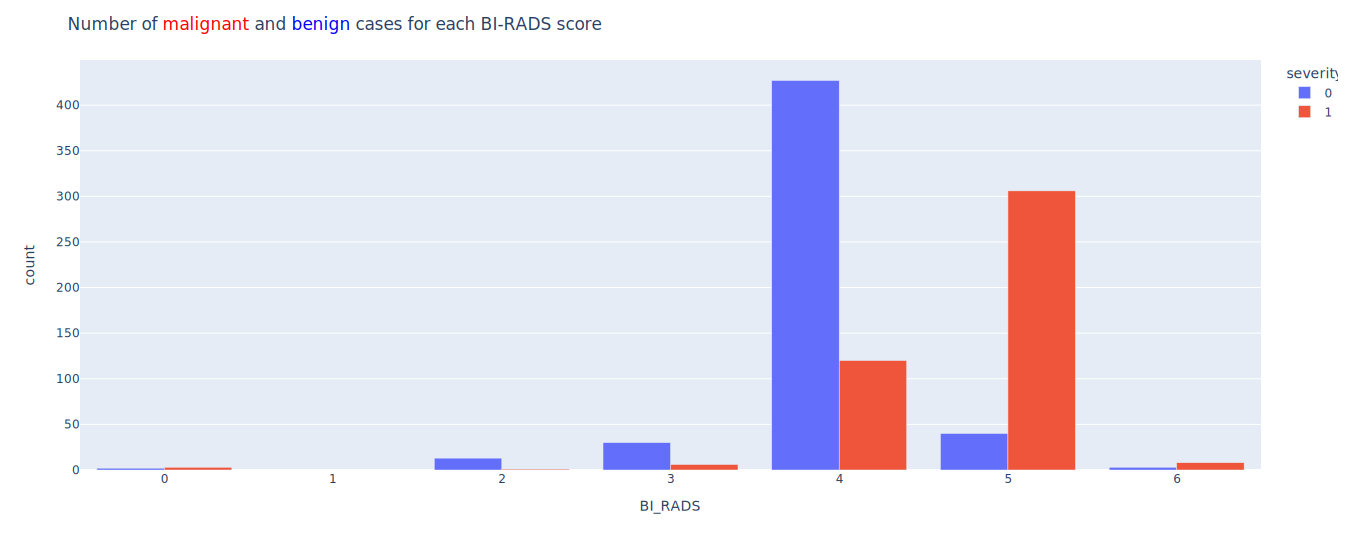

In [6]:
def ratio_plot(data, feature, title=''):
    '''displays a barplot comparing malignant and benign cases'''
    temp = data.rename_axis('count').reset_index()
    temp = temp.groupby([feature, 'severity']).count()['count'].reset_index()
    temp['severity'] = temp['severity'].astype('str')
    fig = px.bar(temp, x=feature, y='count', color='severity', barmode='group')
    fig.update_layout(title=title)
    fig.show("svg", width=1350, height=550)

# fixing a faulty value so that it doesn't skew the graph
data.loc[data[data["BI_RADS"] == 55].index, ["BI_RADS"]] = 5
# Barplot of 'severity' with respect to the different BI-RADS scores
ratio_plot(data, 'BI_RADS', title='Number of <span style="color:red">malignant</span> and <span style="color:blue">benign</span> cases for each BI-RADS score')

We see that a BI-RADS score of 5 almost certainly means malignancy, but a score of 4 does not provide any concrete evidence (recall that 4 covers the whole range from 2% to 94% certainty of malignancy), with most 4-rated masses being labeled benign.

Next we will compute a correlation matrix:

In [7]:
# darker blue indicates higher correlation
data.corr().style.background_gradient(cmap="Blues")

,BI_RADS,age,shape,margin,density,severity
BI_RADS,1.000000,0.288232,0.405930,0.412952,0.082207,0.505132
age,0.288232,1.000000,0.364077,0.411355,0.028954,0.432066
shape,0.405930,0.364077,1.000000,0.742211,0.078666,0.563308
margin,0.412952,0.411355,0.742211,1.000000,0.109392,0.574919
density,0.082207,0.028954,0.078666,0.109392,1.000000,0.064010
severity,0.505132,0.432066,0.563308,0.574919,0.064010,1.000000


In summary, we see that the correlation between *BI_RADS* and *severity* is only 0.5, which is even lower than two of the other predictors (*shape* and *margin*).<br><br>

> **Is AI meant to replace or to augment human phsyicians?**

This is the question we must ask ourselves when considering whether to include the BI-RADS assessments or not. On the one hand - it could bias our model towards making the same errors made by physicians, but on the other hand - it makes sense to use all the information at our disposal. After all, adding human input into the mix may serve our purpose. We do not want to solely rely on AI, nor do we want to leave it entirely up to human judgement.<br><br>

After much consideration, I decided to work with two datasets - one containing the BI-RADS assessments and the other not. This will allow us to compare the results and hopefully reach a conclusion.

In [8]:
# separating our dataset into two copies: with BI_RADS and without.
data_with_BIRADS = data.copy()
data.drop(columns=['BI_RADS'], inplace=True)
data.head()

,age,shape,margin,density,severity
0,67.0,3.0,5.0,3.0,1
1,43.0,1.0,1.0,NaN,1
2,58.0,4.0,5.0,3.0,1
3,28.0,1.0,1.0,3.0,0
4,74.0,1.0,5.0,NaN,1


### Exploring the remaining features

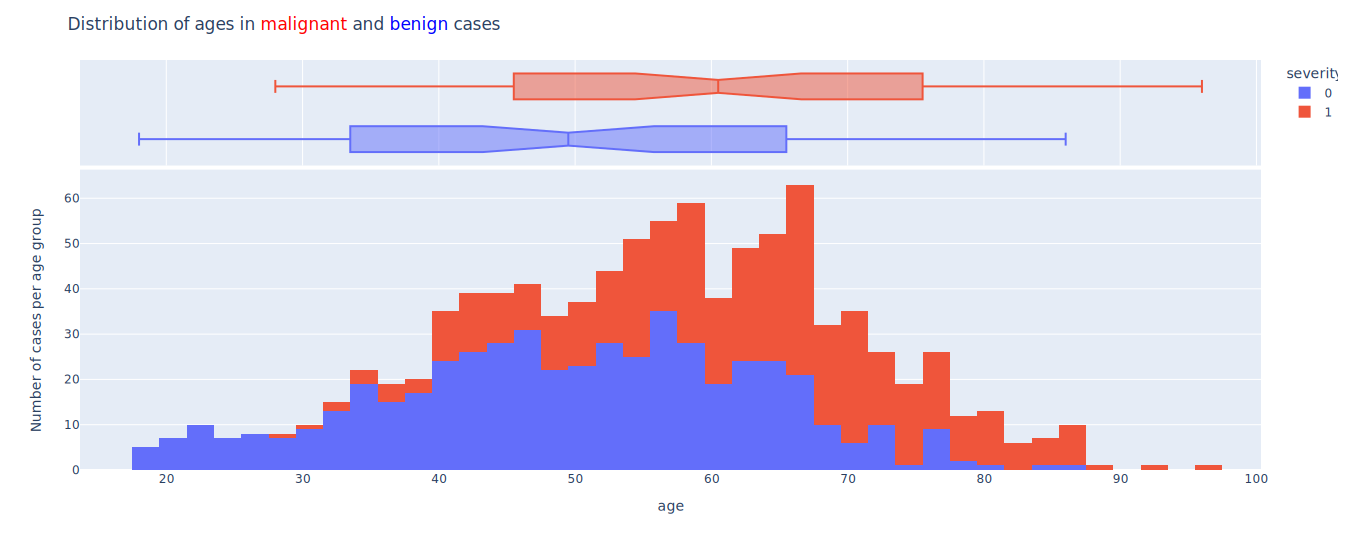

In [9]:
# Age distribution plot
age_data = data.rename_axis('count').reset_index()
age_data = age_data.groupby(['age', 'severity']).count()['count'].reset_index()
age_data['severity'] = age_data['severity'].astype('str')
fig = px.histogram(age_data, x="age", y="count", color="severity",
                   marginal="box", nbins=50)
fig.update_layout(title='Distribution of ages in <span style="color:red">malignant</span> and <span style="color:blue">benign</span> cases',
                  yaxis_title='Number of cases per age group')
fig.show("svg", width=1350, height=550)

We see that older patients have a higher rate of malignancy, as we would expect.

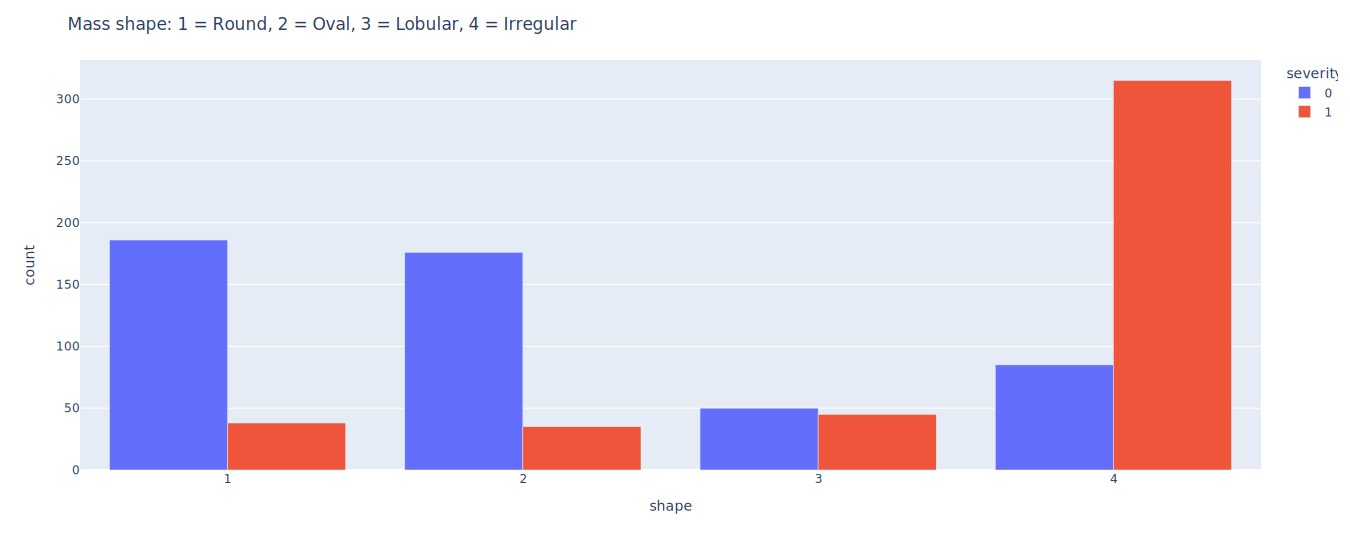

In [10]:
ratio_plot(data, 'shape', title='Mass shape: 1 = Round, 2 = Oval, 3 = Lobular, 4 = Irregular')

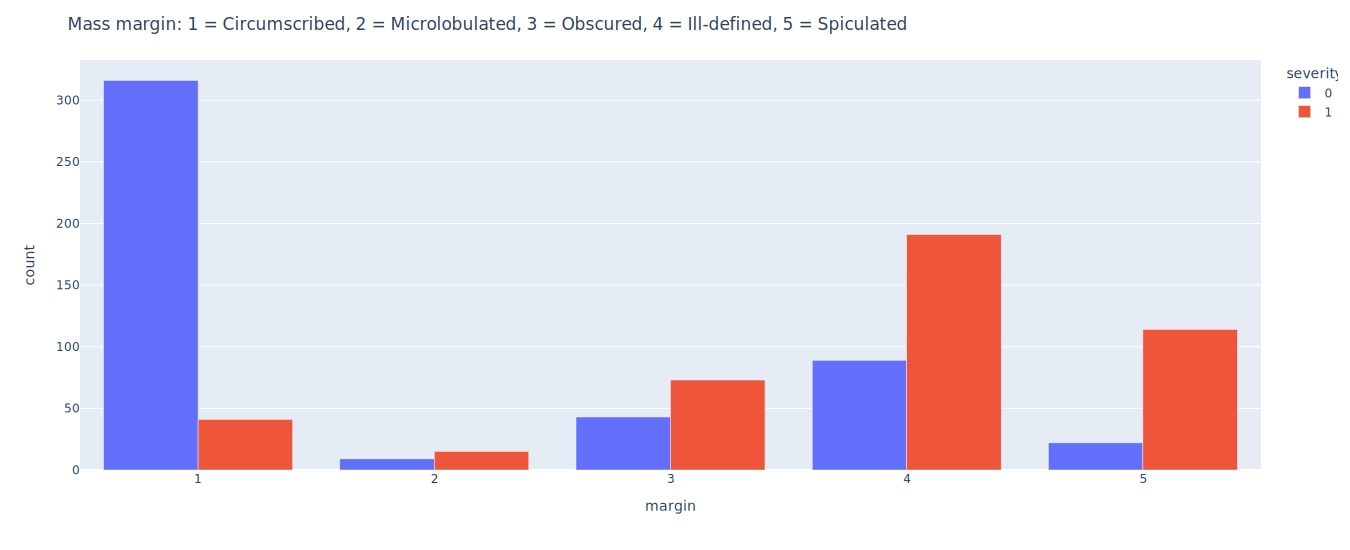

In [11]:
ratio_plot(data, 'margin', title='Mass margin: 1 = Circumscribed, 2 = Microlobulated, 3 = Obscured, 4 = Ill-defined, 5 = Spiculated')

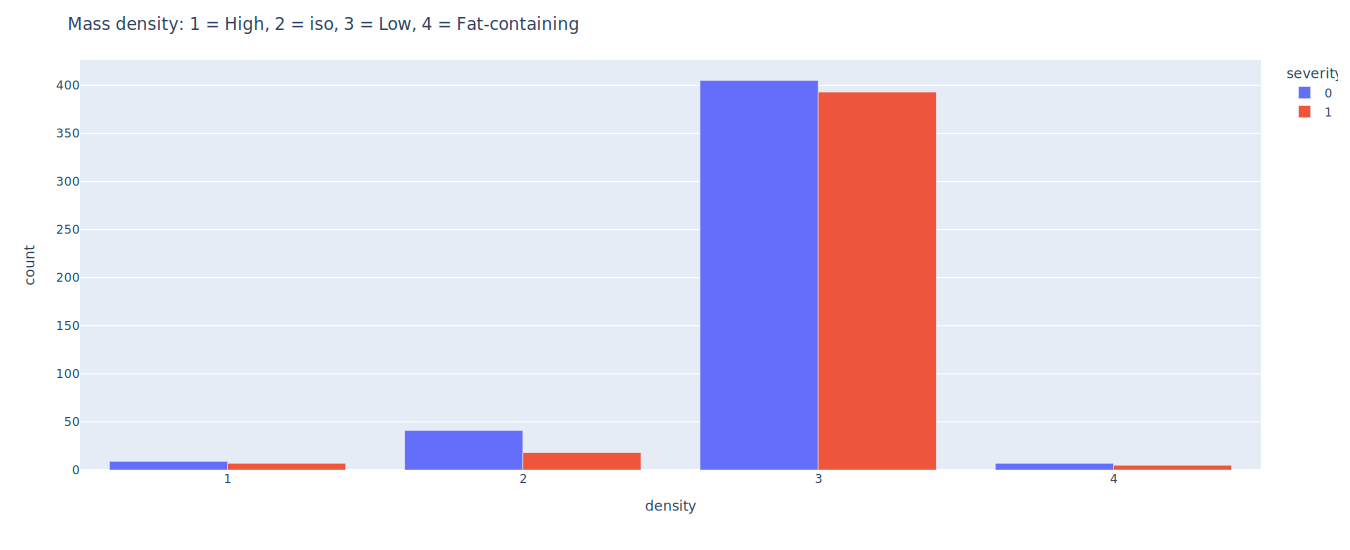

In [15]:
ratio_plot(data, 'density', title='Mass density: 1 = High, 2 = iso, 3 = Low, 4 = Fat-containing')

## Dealing with missing values

In [16]:
print('Number of rows with missing values: ', (data.isna().sum(axis=1) > 0).sum())
print('Number of rows with 2 or more missing values: ', (data.isna().sum(axis=1) > 1).sum())

Number of rows with missing values:  130
Number of rows with 2 or more missing values:  30


Rows with two (or more) missing values leave too little to work with, but we can try to deal with single missing values.

In [17]:
# dropping rows with 2 or more missing values from both datasets
data = data.drop(data[data.isna().sum(axis=1) > 1].index)
data.reset_index(drop=True, inplace=True)
data_with_BIRADS = data_with_BIRADS.drop(data_with_BIRADS[data_with_BIRADS.isna().sum(axis=1) > 1].index)
data_with_BIRADS.reset_index(drop=True, inplace=True)

# remaining missing values per column:
data.isna().sum()

age          5
shape       17
margin      22
density     56
severity     0
dtype: int64

A BI-RADS score of 0 is essentially a missing value, so we will treat it as such.

In [18]:
print('Rows affected: ', (data_with_BIRADS["BI_RADS"] == 0).sum())
data_with_BIRADS.loc[data_with_BIRADS[data_with_BIRADS["BI_RADS"] == 0].index , ["BI_RADS"]] = np.nan
print('Updated BI_RADS range: ', data_with_BIRADS["BI_RADS"].unique())
# range is now 2-6, with 0 being considered NaN ("not a number")

Rows affected:  5
Updated BI_RADS range:  [ 5.  4.  3.  2. nan  6.]


### Dropping vs. Imputing

Since we have such limited data to begin with, it seems criminal to drop 100 rows simply because one of their values is missing. At the same time, trying to impute missing values using only 3 or 4 remaining columns is a difficult task. For this reason, we will once again create two variants of our dataset and pit them against eachother.

In [19]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imputed_row_indexes = data[data.isna().any(axis=1)].index  # we'll save this for later
# trimming the first dataset
trimmed_data = data.dropna()  # simply removing all rows with NaN values
# trimming the second
trimmed_data_with_BIRADS = data_with_BIRADS.dropna()

# first dataset, missing values imputed
imp = IterativeImputer(max_iter=10, random_state=5)
imp.fit(data.dropna())
iterative_array = np.round(imp.transform(data))
imputed_data = pd.DataFrame(iterative_array, columns=cols[1:])
# second dataset, missing values imputed
imp_with_BIRADS = IterativeImputer(max_iter=10, random_state=5)
imp_with_BIRADS.fit(data_with_BIRADS.dropna())
iterative_array = np.round(imp_with_BIRADS.transform(data_with_BIRADS))
imputed_data_with_BIRADS = pd.DataFrame(iterative_array, columns=cols)

print('Imputed data size: ', imputed_data.shape[0], '\nTrimmed data size: ', trimmed_data.shape[0])

Imputed data size:  931 
Trimmed data size:  831


This means we now have a total of 4 datasets:

- BI-RADS: yes |  Missing values: imputed
- BI-RADS: yes |  Missing values: dropped
- BI-RADS: no  |  Missing values: imputed
- BI-RADS: no  |  Missing values: dropped

## Preparing the data for training

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# This will scale all values to a [-1, 1] range. 
# Important mainly for training the logistic regression and neural network models.
numeric_features = ["age", "density", "shape", "margin"]
numeric_features_with_BIRADS = ["BI_RADS", "age", "density", "shape", "margin"]
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, numeric_features)])
preprocessor_with_BIRADS = ColumnTransformer(transformers=[("num", numeric_transformer, numeric_features_with_BIRADS)])

In [21]:
# separating X and y
imputed_X = imputed_data[['age', 'shape', 'margin', 'density']]
imputed_y = imputed_data['severity']
trimmed_X = trimmed_data[['age', 'shape', 'margin', 'density']]
trimmed_y = trimmed_data['severity']
# second dataset
imputed_with_BIRADS_X = imputed_data_with_BIRADS[['BI_RADS', 'age', 'shape', 'margin', 'density']]
imputed_with_BIRADS_y = imputed_data_with_BIRADS['severity']
trimmed_with_BIRADS_X = trimmed_data_with_BIRADS[['BI_RADS', 'age', 'shape', 'margin', 'density']]
trimmed_with_BIRADS_y = trimmed_data_with_BIRADS['severity']

In [22]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
# splitting our data into train and test sets; 75/25
trimmed_X_train, trimmed_X_test, trimmed_y_train, trimmed_y_test = train_test_split(trimmed_X, trimmed_y,
                                                                                    test_size=0.25, random_state=5)
imputed_X_train, imputed_X_test, imputed_y_train, imputed_y_test = train_test_split(imputed_X, imputed_y,
                                                                                    test_size=0.25, random_state=5)
trimmed_BIRADS_X_train, trimmed_BIRADS_X_test, trimmed_BIRADS_y_train, trimmed_BIRADS_y_test = train_test_split(trimmed_with_BIRADS_X, trimmed_with_BIRADS_y,
                                                                                    test_size=0.25, random_state=5)
imputed_BIRADS_X_train, imputed_BIRADS_X_test, imputed_BIRADS_y_train, imputed_BIRADS_y_test = train_test_split(imputed_with_BIRADS_X, imputed_with_BIRADS_y,
                                                                                    test_size=0.25, random_state=5)

## Training classification models

### *Random Forest*

In [25]:
from sklearn.ensemble import RandomForestClassifier

BIRADS_rf_pipeline = Pipeline(
    steps=[("preprocessor", preprocessor_with_BIRADS), ("classifier", RandomForestClassifier())]
)
rf_pipeline = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", RandomForestClassifier())]
)

parameters = {'classifier__max_depth':[2, 3]}
trimmed_rf_grid = GridSearchCV(rf_pipeline, parameters, cv=10)
imputed_rf_grid = GridSearchCV(rf_pipeline, parameters, cv=10)
BIRADS_trimmed_rf_grid = GridSearchCV(BIRADS_rf_pipeline, parameters, cv=10)
BIRADS_imputed_rf_grid = GridSearchCV(BIRADS_rf_pipeline, parameters, cv=10)

imputed_rf = imputed_rf_grid.fit(imputed_X_train, imputed_y_train)
trimmed_rf = trimmed_rf_grid.fit(trimmed_X_train, trimmed_y_train)
trimmed_BIRADS_rf = BIRADS_trimmed_rf_grid.fit(trimmed_BIRADS_X_train, trimmed_BIRADS_y_train)
imputed_BIRADS_rf = BIRADS_imputed_rf_grid.fit(imputed_BIRADS_X_train, imputed_BIRADS_y_train)

print('trimmed train results: ', trimmed_rf.cv_results_['mean_test_score'],
      '\nimputed train results: ', imputed_rf.cv_results_['mean_test_score'],
      '\ntrimmed BIRADS train results: ', trimmed_BIRADS_rf.cv_results_['mean_test_score'],
      '\nimputed BIRADS train results: ', imputed_BIRADS_rf.cv_results_['mean_test_score'])

trimmed train results:  [0.80586278 0.81390169] 
imputed train results:  [0.80650104 0.8136853 ] 
trimmed BIRADS train results:  [0.83826018 0.84476467] 
imputed BIRADS train results:  [0.8352588  0.83956522]


Prediction accuracy on the unseen test set along with confusion matrices:

In [26]:
from sklearn.metrics import confusion_matrix

def test_score(name, model, train_data, test_data):
  temp = model.predict(train_data)
  print(name, "results: %.3f" % model.score(train_data, test_data))
  print(confusion_matrix(test_data, temp))

test_score('Trimmed test', trimmed_rf, trimmed_X_test, trimmed_y_test)
print('\n')
test_score('Imputed test', imputed_rf, imputed_X_test, imputed_y_test)
print('\n')
test_score('Trimmed BIRADS test', trimmed_BIRADS_rf, trimmed_BIRADS_X_test, trimmed_BIRADS_y_test)
print('\n')
test_score('Imputed BIRADS test', imputed_BIRADS_rf, imputed_BIRADS_X_test, imputed_BIRADS_y_test)

Trimmed test results: 0.784
[[74 24]
 [21 89]]


Imputed test results: 0.815
[[93 24]
 [19 97]]


Trimmed BIRADS test results: 0.836
[[86 22]
 [12 87]]


Imputed BIRADS test results: 0.850
[[106  11]
 [ 24  92]]


Out of curiosity, let us try using only the rows with imputed values as our test set.

In [27]:
# using the row indices we saved from earlier
imputed_rows = data.iloc[imputed_row_indexes].copy()
imputed_train = data.drop(imputed_row_indexes).copy()
imp = IterativeImputer(max_iter=10, random_state=5)  # imputing again using the same seed
imp.fit(imputed_train)
iterative_array = np.round(imp.transform(imputed_rows))
imputed_rows = pd.DataFrame(iterative_array, columns=cols[1:])

imputed_train_X = imputed_train[['age', 'shape', 'margin', 'density']]
imputed_train_y = imputed_train['severity']
imputed_test_X = imputed_rows[['age', 'shape', 'margin', 'density']]
imputed_test_y = imputed_rows['severity']

# training a random forest model on all rows except those which had missing values
rf_vs_imp_grid = GridSearchCV(rf_pipeline, parameters, cv=10)
rf_vs_imp = rf_vs_imp_grid.fit(imputed_train_X, imputed_train_y)
print('Training results on rows excluding missing values: ', rf_vs_imp.cv_results_['mean_test_score'], '\n')
test_score('Prediction accuracy on rows containing imputed', rf_vs_imp, imputed_test_X, imputed_test_y)

Training results on rows excluding missing values:  [0.80150602 0.80149168] 

Prediction accuracy on rows containing imputed results: 0.730
[[44 22]
 [ 5 29]]


The results are worse, as we would expect, but not too bad when considering that one of the four features in each row has been artificially filled in by the IterativeImputer.

### *Neural Network*

In [28]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [31]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

# simple two layer network with a 50% dropout in between to prevent overfitting
def create_model():
    model = Sequential()
    model.add(Dense(10, input_dim=4, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def create_model_with_BIRADS():
    '''Only difference is the size of input_dim'''
    model = Sequential()
    model.add(Dense(10, input_dim=5, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# training four neural networks; one for each dataset.
nn_pipeline = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", KerasClassifier(build_fn=create_model, epochs=30, verbose=0))]
)
BIRADS_nn_pipeline = Pipeline(
    steps=[("preprocessor", preprocessor_with_BIRADS), ("classifier", KerasClassifier(build_fn=create_model_with_BIRADS, epochs=30, verbose=0))]
)
parameters={}
imputed_nn = GridSearchCV(nn_pipeline, parameters, cv=5)
trimmed_nn = GridSearchCV(nn_pipeline, parameters, cv=5)
imputed_BIRADS_nn = GridSearchCV(BIRADS_nn_pipeline, parameters, cv=5)
trimmed_BIRADS_nn = GridSearchCV(BIRADS_nn_pipeline, parameters, cv=5)

imputed_nn = imputed_nn.fit(imputed_X_train, imputed_y_train)
trimmed_nn = trimmed_nn.fit(trimmed_X_train, trimmed_y_train)
imputed_BIRADS_nn = imputed_BIRADS_nn.fit(imputed_BIRADS_X_train, imputed_BIRADS_y_train)
trimmed_BIRADS_nn = trimmed_BIRADS_nn.fit(trimmed_BIRADS_X_train, trimmed_BIRADS_y_train)

print('trimmed train results: ', trimmed_nn.cv_results_['mean_test_score'],
      '\nimputed train results: ', imputed_nn.cv_results_['mean_test_score'],
      '\ntrimmed BIRADS train results: ', trimmed_BIRADS_nn.cv_results_['mean_test_score'],
      '\nimputed BIRADS train results: ', imputed_BIRADS_nn.cv_results_['mean_test_score'])

trimmed train results:  [0.80736775] 
imputed train results:  [0.80226105] 
trimmed BIRADS train results:  [0.83494624] 
imputed BIRADS train results:  [0.82655704]


In [32]:
test_score('Trimmed test', trimmed_nn, trimmed_X_test, trimmed_y_test)
print('\n')
test_score('Imputed test', imputed_nn, imputed_X_test, imputed_y_test)
print('\n')
test_score('Trimmed BIRADS test', trimmed_BIRADS_nn, trimmed_BIRADS_X_test, trimmed_BIRADS_y_test)
print('\n')
test_score('Imputed BIRADS test', imputed_BIRADS_nn, imputed_BIRADS_X_test, imputed_BIRADS_y_test)

7/7 [==============================] - 0s 2ms/step
Trimmed test results: 0.793
[[74 24]
 [19 91]]


8/8 [==============================] - 0s 2ms/step
Imputed test results: 0.811
[[95 22]
 [22 94]]


7/7 [==============================] - 0s 2ms/step
Trimmed BIRADS test results: 0.845
[[90 18]
 [14 85]]


8/8 [==============================] - 0s 2ms/step
Imputed BIRADS test results: 0.845
[[102  15]
 [ 21  95]]


### *Logistic Regression*

In [34]:
from sklearn.linear_model import LogisticRegression

logreg_pipeline = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
)

logreg_BIRADS_pipeline = Pipeline(
    steps=[("preprocessor", preprocessor_with_BIRADS), ("classifier", LogisticRegression())]
)

parameters = {}
imputed_lr = GridSearchCV(logreg_pipeline, parameters, cv=10)
imputed_lr = imputed_lr.fit(imputed_X_train, imputed_y_train)

trimmed_lr = GridSearchCV(logreg_pipeline, parameters, cv=10)
trimmed_lr = trimmed_lr.fit(trimmed_X_train, trimmed_y_train)

imputed_BIRADS_lr = GridSearchCV(logreg_BIRADS_pipeline, parameters, cv=10)
imputed_BIRADS_lr = imputed_BIRADS_lr.fit(imputed_BIRADS_X_train, imputed_BIRADS_y_train)

trimmed_BIRADS_lr = GridSearchCV(logreg_BIRADS_pipeline, parameters, cv=10)
trimmed_BIRADS_lr = trimmed_BIRADS_lr.fit(trimmed_BIRADS_X_train, trimmed_BIRADS_y_train)

print('trimmed train results: ', trimmed_lr.cv_results_['mean_test_score'],
      '\nimputed train results: ', imputed_lr.cv_results_['mean_test_score'],
      '\ntrimmed BIRADS train results: ', trimmed_BIRADS_lr.cv_results_['mean_test_score'],
      '\nimputed BIRADS train results: ', imputed_BIRADS_lr.cv_results_['mean_test_score'])

trimmed train results:  [0.80586278] 
imputed train results:  [0.79364389] 
trimmed BIRADS train results:  [0.84315177] 
imputed BIRADS train results:  [0.83233954]


In [35]:
test_score('Trimmed test', trimmed_lr, trimmed_X_test, trimmed_y_test)
print('\n')
test_score('Imputed test', imputed_lr, imputed_X_test, imputed_y_test)
print('\n')
test_score('Trimmed BIRADS test', trimmed_BIRADS_lr, trimmed_BIRADS_X_test, trimmed_BIRADS_y_test)
print('\n')
test_score('Imputed BIRADS test', imputed_BIRADS_lr, imputed_BIRADS_X_test, imputed_BIRADS_y_test)

Trimmed test results: 0.793
[[74 24]
 [19 91]]


Imputed test results: 0.803
[[95 22]
 [24 92]]


Trimmed BIRADS test results: 0.855
[[92 16]
 [14 85]]


Imputed BIRADS test results: 0.854
[[105  12]
 [ 22  94]]


## In Summary
> **Model Performance**

The results may seem surprising at first, but in retrospect it seems reasonable that, given this simple and limited dataset, the simpler models outperform the complex ones.

Taking the highest accuracy achieved by each model class, we get:

- 1. Logistic Regression: 85.5%
- 2. Random Forest: 85%
- 3. Neural Network: 84.5%

Clearly, the results are too similar to say anything meaningful about the different model classes. If anything, this teaches us that the data's quality often has far more influence over the final outcome than our choice of model class.<br><br>


> **Dropping vs. Imputing**

Looking at the BIRADS-free models, we see consistently better results with missing values imputed rather than dropped. The models trained with BI-RADS, on the other hand, show very similar results regardless of the method used to deal with missing values.

My theory is that the models trained on only 4 variables have more to gain by preserving 100 rows with missing values, whereas the models trained with the addition of BI-RADS scores can achieve equal results with less data.<br><br>

> **BI-RADS?**

The models trained with the addition of BI-RADS scores were consistently 3-5% more accurate, both in training and in testing. Perhaps we may have expected an even greater jump in performance, yet, whichever way we look at it, going strictly by the numbers-- the addition of BI-RADS scores undeniably improves the results. That said, the question of whether or not to include BI-RADS scores remains an open one. It may be that we prefer our model to remain unbiased by human judgement, so that we may look at the model's predictions alongside the physicians assessments in order to make educated decisions.